In [1]:
# A little thing to suppress warnings I know will come up...comment off for testing
#import warnings
#warnings.filterwarnings("ignore", category=RuntimeWarning)

In [1]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.interpolate import interp1d

c,gc = 2.9979*1e8, 6.6726*1e-11
MeV = 1.602*1e-13
Msol = 1.98892*1e30

rs = Msol*gc/c**2/1000
conv = rs*MeV*1e54/Msol/c**2
nuc_to_astro = conv
print(nuc_to_astro)

def read_eos(pathname):
    """
    Read in equation of state information from tabulated format.
    This is written assuming the following order:
    0: number density [fm-3]
    1: pressure [Mev fm-3]
    2: energy density [Mev fm-3]
    Conversion factor: 1 [Mev fm-3] = 1.323x10^-6 [Msol c2 km-3]
    """
    
    src = np.loadtxt(pathname)#, comments='#')
    P, e = src[:,1], src[:,2]
    p, e = P*nuc_to_astro, e*nuc_to_astro
    return (p,e)
    
def make_derivs_func(pathname):
    pdata, edata = read_eos(pathname)
    eos = interp1d(pdata,edata,fill_value='extrapolate')
    
    def derivs(p,y):
        """
        e: e_of_P function
        """
        e = eos(p)
        x,m = y
        dxdp = -2*x*(np.sqrt(x)-(2*m))/((e+p)*(m+(4*np.pi*p*x**(3/2))))
        dmdp = -((4*np.pi*e*x**(3/2))*(np.sqrt(x)-2*m))/((e+p)*(m+(4*np.pi*p*x**(3/2))))
        return dxdp,dmdp
    
    return derivs

def solve_tov(p_init,pathname):
    """
    Inputs:
    - p,e: functions for EOS
    - p_init: Value of central pressure (start with 0.8*nuc_to_astro)
    Initial conditions: P(0) = P[index]
    Note: I took max_step out for now because it seems to work fine without it, 
    and including it slows down the calculation considerably  # Try: BDF, Radau
    """
    
    derivs = make_derivs_func(pathname)

    p_range = [p_init,1e-16]
    y0 = [1e-14,1e-14]
    sol = solve_ivp(derivs, p_range, y0, dense_output=True, 
                    rtol=1e-6, atol=1e-7, method='LSODA')
    return sol

1.3233936131549898e-06


In [8]:
import traceback
import glob

path = '/home/kalund/EOS_playground/'
radmass,EOS_names = {}, glob.glob(path+'*/')
for EOS in EOS_names:
    eos = EOS.split('/')[-2]
    #print(eos)
    radmass[eos] = []
P_vals = np.geomspace(2,300000,70)
for P in P_vals:
    try:
        init_p = P*nuc_to_astro
        for eos in radmass.keys():
            #print(eos)
            pathname = path + eos + '/' + eos + '.dat'
            sol = solve_tov(init_p, pathname)
            radmass[eos].append([np.sqrt(sol.y[0][-1]), sol.y[1][-1]/rs])
    except:
        print(eos,'error')
        traceback.print_exc()
for eos in radmass.keys():
    radmass[eos] = np.array(radmass[eos])
    print('Maximum mass using',eos, ': %1.2f M_sun'%max(radmass[eos][:,1]))
print('\n')

Maximum mass using PCGS_PCSB0 : 2.53 M_sun
Maximum mass using BL_chiral : 2.08 M_sun
Maximum mass using SLy : 2.05 M_sun
Maximum mass using CMGO_GDFM-II : 2.30 M_sun
Maximum mass using RG_KDE0v1 : 1.97 M_sun
Maximum mass using VGBCMR_D1M : 1.75 M_sun




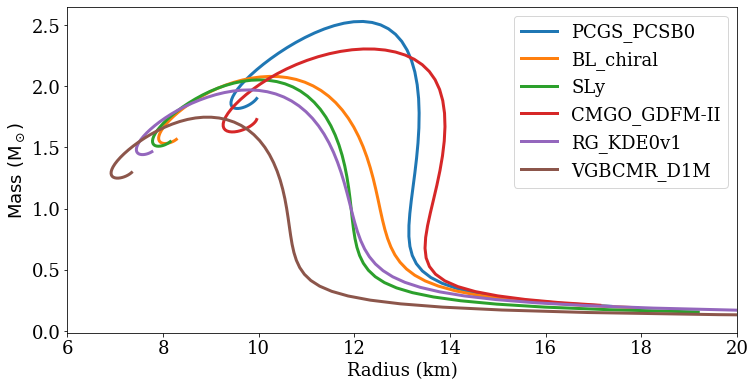

In [10]:
plt.rcParams['font.family'],plt.rcParams['font.size'] = 'serif',18

plt.figure(figsize=(12,6))
for method in radmass.keys():
    radius,mass = radmass[method][:,0],radmass[method][:,1]
    plt.plot(radius, mass, linewidth=3,label=method)#), color=colors[method])
    #plt.scatter(radius, mass, color=colors[method])
plt.legend(loc='best')
_ = plt.xlabel('Radius (km)'), plt.ylabel(r'$\rm{Mass\ (M_\odot)}$')
plt.xlim(6,20)
plt.savefig('massradius_highP.png', bbox_inches='tight', facecolor='w')

In [ ]:
#DO NOT TOUCH

In [ ]:
np.sqrt(rs)